**Part 1: Setup Load Data**

1.1 Install Dependencies and Setup

In [4]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt

In [2]:
gpus= tf.config.experimental.list_physical_devices('GPU')

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus= tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
os.listdir('drive/MyDrive/Colab Notebooks/data')

['happy', 'sad']

1.2 Remove dodgy images

In [6]:
import  cv2
import imghdr

/tmp/ipython-input-3027993907.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'drive/MyDrive/Colab Notebooks/data'

In [8]:
os.listdir(data_dir)

['happy', 'sad']

In [9]:
img = cv2.imread(os.path.join(data_dir,'happy','154006829.jpg'))

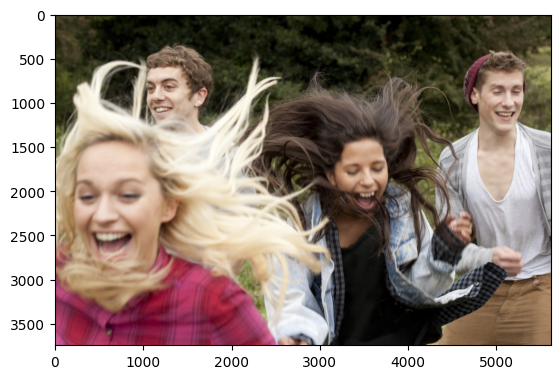

In [10]:
#This line shows an OpenCV-loaded image correctly in Matplotlib by converting from BGR (OpenCV default) to RGB (Matplotlib default).
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [11]:
image_exts = ['jpeg','jpg','bmp','png']

In [12]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path = os.path.join(data_dir,image_class,image)
    try:
      img = cv2.imread(image_path)
      typ = imghdr.what(image_path)
      if typ not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
        print('Issue with image {}'.format(image_path))

**1.3 Load Data**

In [13]:
tf.data.Dataset??

In [90]:
import numpy as np


In [22]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 305 files belonging to 2 classes.


In [23]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
data_iterator = data.as_numpy_iterator()

In [25]:
batch = data_iterator.next()

In [20]:
# Get another Batch from the itrerator
batch1 = data_iterator.next()

In [26]:
# Images represented as numpy array
batch[0].shape

(32, 256, 256, 3)

In [27]:
batch[1]

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0], dtype=int32)

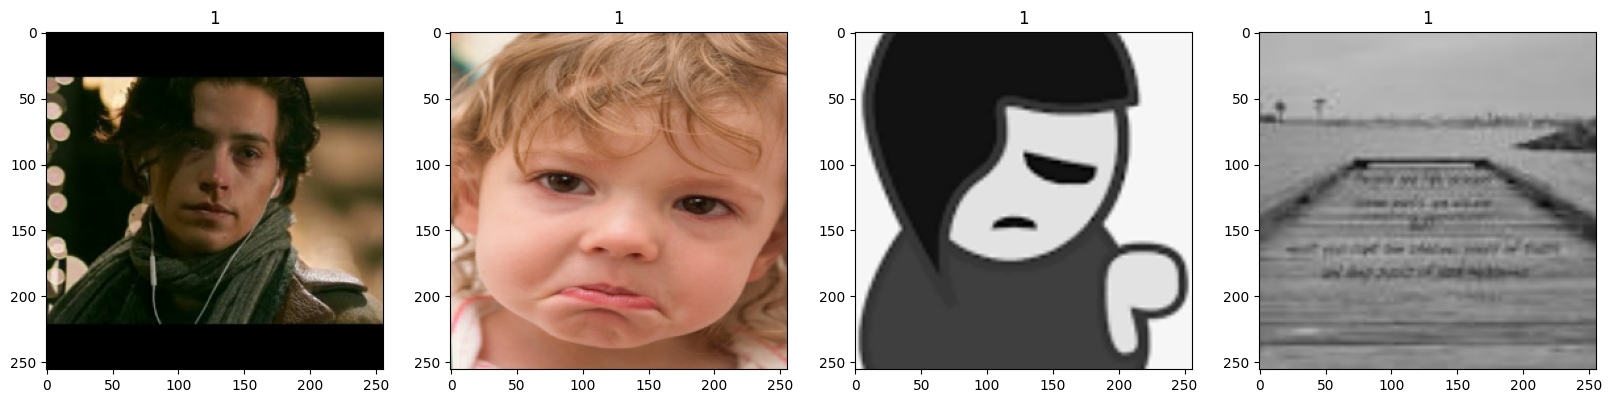

In [28]:
fig , ax =plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [30]:
# scale
scale = batch[0]/255

In [31]:
scale.max()

np.float32(1.0)

**2. Preprocess Data**

2.1. Scale Data

In [33]:
data = data.map(lambda x,y:(x/255,y))

In [34]:
scaled_iterator = data.as_numpy_iterator()

In [36]:
batch = scaled_iterator.next()

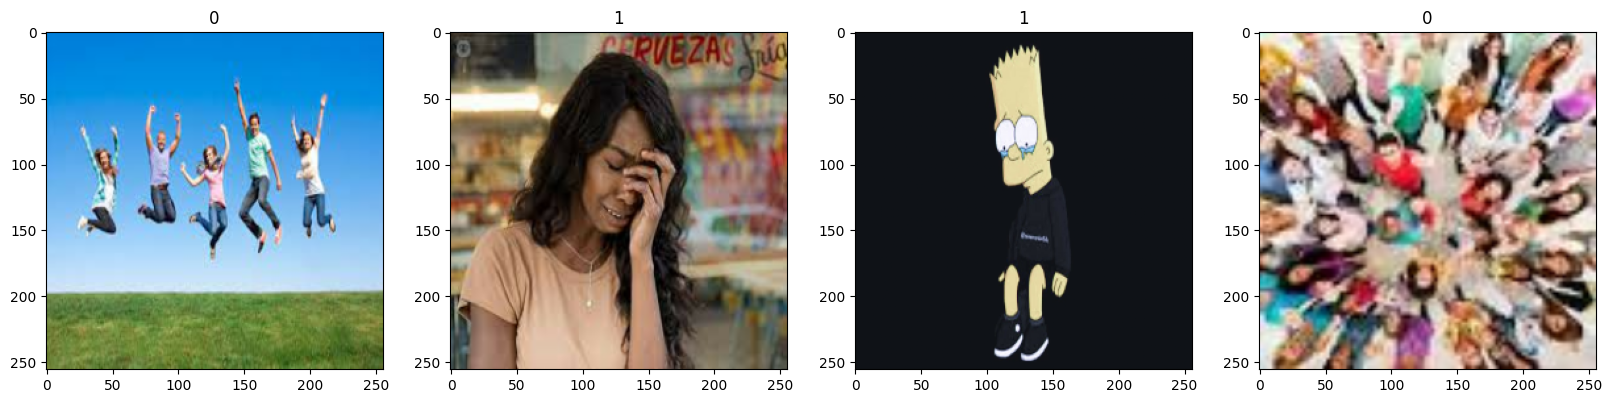

In [41]:
fig , ax =plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

**2.2 Split Data**

In [42]:
len(data)

10

In [43]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [47]:
val_size+test_size+train_size

10

In [48]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [51]:
len(test)

1

**3.Deep Model** <br>
3.1 Build Deep Learning Model

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D ,Dense,Flatten ,Dropout

In [55]:
model = Sequential()

In [57]:
model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [63]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 252, 252, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,698,945 (14.11 MB)

 Trainable params: 3,698,945 (14.11 MB)

 Non-trainable params: 0 (0.00 B)

**3.2 Train**

In [60]:
logdir = 'drive/MyDrive/Colab Notebooks/logs'

In [61]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [65]:
hist = model.fit(train,epochs=20,validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.5152 - loss: 0.7136 - val_accuracy: 0.4844 - val_loss: 0.6245
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.6355 - loss: 0.6233 - val_accuracy: 0.5000 - val_loss: 0.6284
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.6820 - loss: 0.5546 - val_accuracy: 0.6562 - val_loss: 0.5224
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.7732 - loss: 0.4218 - val_accuracy: 0.8906 - val_loss: 0.3125
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.8369 - loss: 0.3827 - val_accuracy: 0.9688 - val_loss: 0.2470
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.8685 - loss: 0.2865 - val_accuracy: 0.9844 - val_loss: 0.1352
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.9453 - loss: 0.1645 - val_accuracy: 0.9688 - val_loss: 0.1742
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.9738 - loss: 0.0837 - val_accuracy: 0.9688 - val_loss: 0.1220
Epoch 9/

**3.3 Plot Performance**

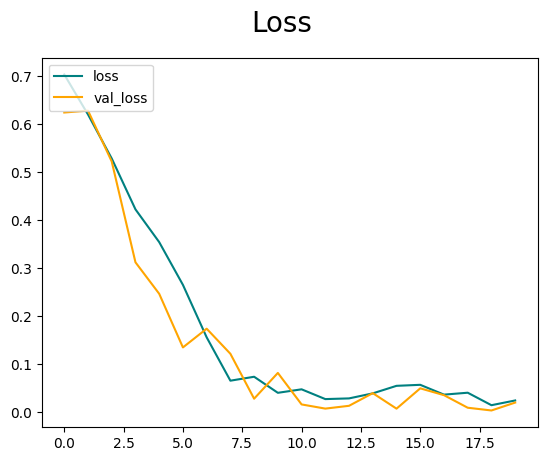

In [69]:
fig = plt.figure()

plt.plot(hist.history['loss'],color="teal", label="loss")
plt.plot(hist.history['val_loss'],color="orange", label="val_loss")
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

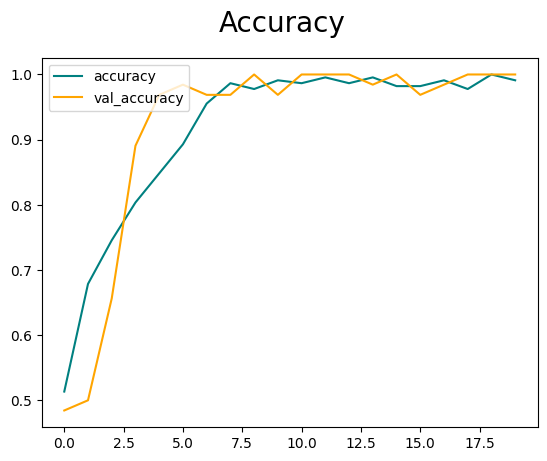

In [70]:
fig = plt.figure()

plt.plot(hist.history['accuracy'],color="teal", label="accuracy")
plt.plot(hist.history['val_accuracy'],color="orange", label="val_accuracy")
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

**4. Evaluated Perfomance**

4.1 **Evaluated**

In [71]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [72]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [73]:
for batch in test.as_numpy_iterator():
  X,y = batch
  yhat = model.predict(X)
  pre.update_state(y,yhat)
  re.update_state(y,yhat)
  acc.update_state(y,yhat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


In [74]:
print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}")

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


**4.2 Test**

In [75]:
test_dir ='drive/MyDrive/Colab Notebooks/imageTest'

In [81]:
happyImage = os.path.join(test_dir,'happyTest.jpg')
sadImage = os.path.join(test_dir,'sadTest.jpg')

In [79]:
happyImage

'drive/MyDrive/Colab Notebooks/imageTest/happyTest.jpg'

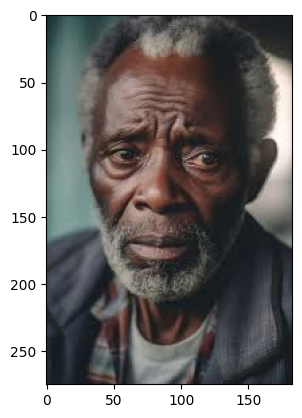

In [84]:
img = cv2.imread(sadImage)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

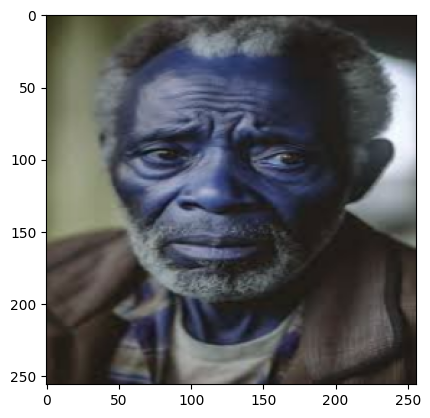

In [88]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [91]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


In [92]:
yhat

array([[0.80095583]], dtype=float32)

In [93]:
if yhat > 0.5 :
  print(f'Predicted cless is Sad')
else:
  print(f'Predicted cless is Happy')

Predicted cless is Sad


**5. Save The Model**

In [94]:
from tensorflow.keras.models import load_model

In [95]:
model.save(os.path.join('drive/MyDrive/Colab Notebooks/models','happySadModel.h5'))

In [96]:
new_model = load_model(os.path.join('drive/MyDrive/Colab Notebooks/models','happySadModel.h5'))

In [97]:
new_model

<Sequential name=sequential, built=True>

In [98]:
new_model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


array([[0.80095583]], dtype=float32)